In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

In [ ]:

def read_data():
    """
    Reads and loads control and test group data from CSV files.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the CSV file for the control group.
    """
    # Maximum Bidding (Existing)
    control = pd.read_csv("/content/sample_data/control_group.csv", sep=';')

    # Average Bidding (New)
    test = pd.read_csv("/content/sample_data/test_group.csv", sep=';')

    # Remove specific rows from control dataframe
    control.dropna(inplace=True)

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, boyut, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in boyut :
        for j in boyut :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

In [ ]:
from google.colab import files
import shutil

# Upload files
uploaded = files.upload()

# Move files to 'sample_data' folder
for filename in uploaded.keys():
    shutil.move(filename, f'/content/sample_data/{filename}')

Saving control_group.csv to control_group.csv
Saving test_group.csv to test_group.csv


In [ ]:
control = pd.read_csv('/content/sample_data/control_group.csv', delimiter=';')
test = pd.read_csv('/content/sample_data/test_group.csv', delimiter=';')

In [ ]:
#TODO : print what is control
control = pd.read_csv('/content/sample_data/control_group.csv', delimiter=';')
control['Date'] = pd.to_datetime(control['Date'], dayfirst=True)

#TODO : check for null values in control
# Most data for 2019-08-05 missing, so dropped row
control.drop(labels=[4], axis=0, inplace=True)
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2019-08-01,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2019-08-02,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,2019-08-03,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,2019-08-04,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
5,Control Campaign,2019-08-06,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0


In [ ]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [ ]:
#TODO : check for null values in control
control.isnull().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
Reach,1
# of Website Clicks,1
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,1


In [ ]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).

control, control_kat_control, control_cat_col  = get_catvar(control)
control, control_num_df, control_num_col = get_numvar(control_cat_col, control)

#TODO :produces lists of column names for both categories for further use or reference.
print(control_cat_col)
print(control_num_col)

['Campaign Name', 'Date']
['Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [ ]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.
control_num_df_complete = fill_NaNValue(control_num_df)

In [ ]:
# TODO : Combine categorical and numerical variables with the concept.
# Concatenate along columns (axis=1)
control = pd.concat([control_kat_control, control_num_df_complete], axis=1)

In [ ]:
# Let's do a data type conversion.

control = convert_datatype(control)

print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [ ]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     float64
 3   # of Impressions     30 non-null     int64  
 4   Reach                30 non-null     int64  
 5   # of Website Clicks  30 non-null     int64  
 6   # of Searches        30 non-null     int64  
 7   # of View Content    30 non-null     int64  
 8   # of Add to Cart     30 non-null     int64  
 9   # of Purchase        30 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

In [ ]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?

control, test = feature_engineering(control, test)

#TODO : Prepare and generate features for visualization with the help of a function

AB, control_nop, test_nop = data_prepare_for_visualization(control, test)

In [ ]:
AB["Group"].value_counts()

,count
Group,
A (MaximumBidding),30
B (AverageBidding),30


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

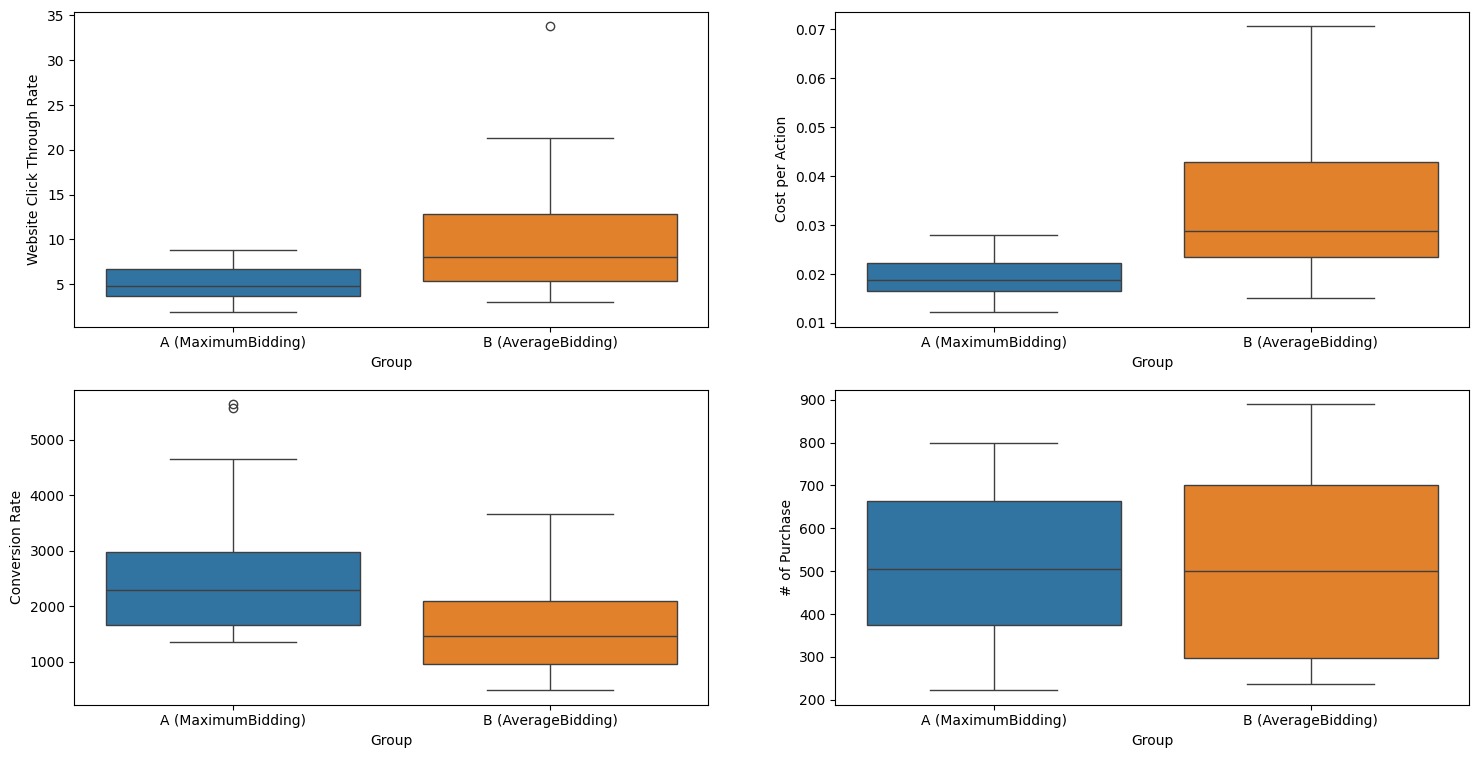

In [ ]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [ ]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.
group_A = AB[AB['Group']=='A (MaximumBidding)'][['# of Purchase','Website Click Through Rate','Cost per Action','Conversion Rate']]
group_B = AB[AB['Group']=='B (AverageBidding)'][['# of Purchase','Website Click Through Rate','Cost per Action','Conversion Rate']]

print(group_A.head(3))
print('*'*30)
print(group_B.head(3))

   # of Purchase  Website Click Through Rate  Cost per Action  Conversion Rate
0            618                    8.483471         0.023602      1376.909920
1            511                    6.700264         0.013039      1661.578298
2            372                    4.941121         0.016383      2197.464659
******************************
   # of Purchase  Website Click Through Rate  Cost per Action  Conversion Rate
0            255                    7.681416         0.064339      1538.907176
1            677                    4.623755         0.022934      2380.051535
2            578                   11.222123         0.027845      1077.146481


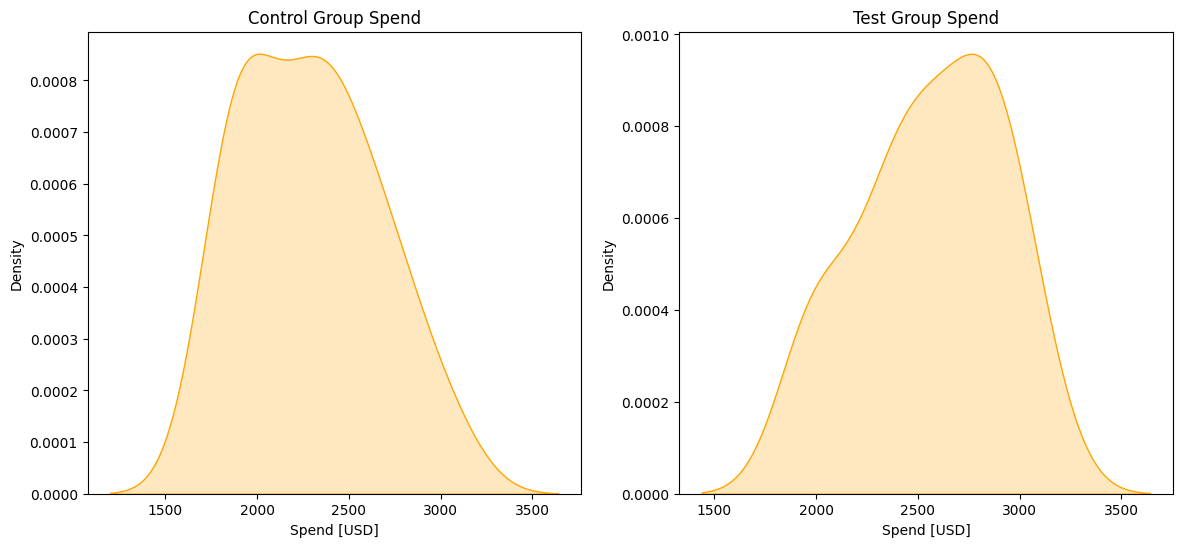

In [43]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax1 = sns.kdeplot(control['Spend [USD]'], ax=ax[0], color='orange', fill=True)
ax2 = sns.kdeplot(test['Spend [USD]'], ax=ax[1], color='orange', fill=True)
ax1.set_title('Control Group Spend')
ax2.set_title('Test Group Spend')

plt.show()

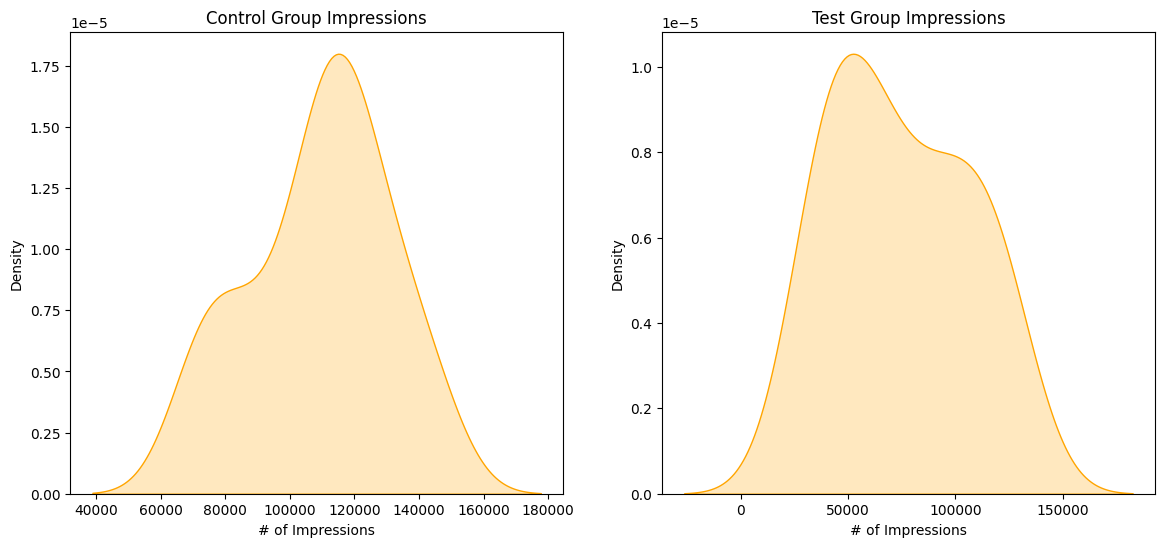

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))

ax1 = sns.kdeplot(control['# of Impressions'], ax=ax[0], color='orange', fill=True)
ax2 = sns.kdeplot(test['# of Impressions'], ax=ax[1], color='orange', fill=True)
ax1.set_title('Control Group Impressions')
ax2.set_title('Test Group Impressions')

plt.show()

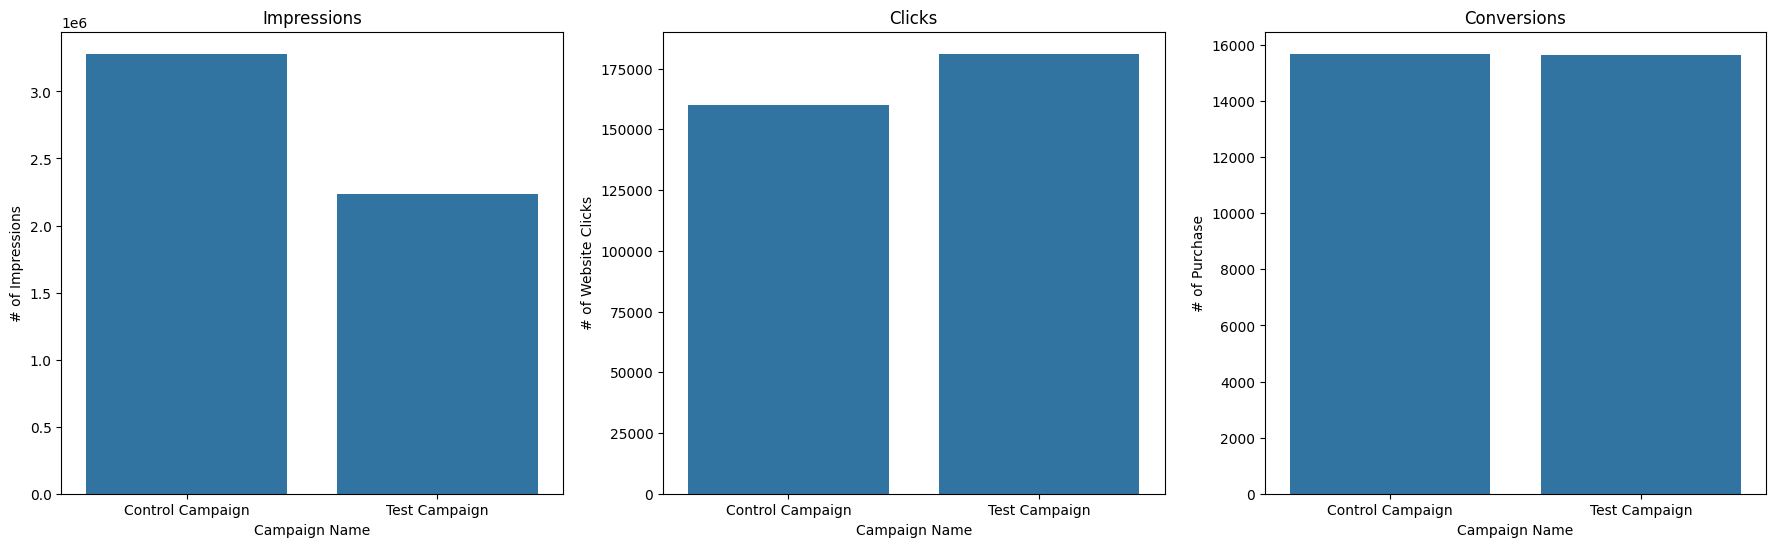

In [45]:
data_all = pd.concat([control, test])
fig, ax = plt.subplots(ncols=3, figsize=(22,6))
ax1 = sns.barplot(data=data_all, x='Campaign Name', y='# of Impressions', errorbar=('ci', False), ax=ax[0], estimator='sum')
ax2 = sns.barplot(data=data_all, x='Campaign Name', y='# of Website Clicks', errorbar=('ci', False), ax=ax[1], estimator='sum')
ax3 = sns.barplot(data=data_all, x='Campaign Name', y='# of Purchase', errorbar=('ci', False), ax=ax[2], estimator='sum')

ax1.set_title('Impressions')
ax2.set_title('Clicks')
ax3.set_title('Conversions')

plt.show()